In [1]:
import os, random, math, time, gc
import numpy as np
import torch

print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

PyTorch: 2.6.0+cu124
CUDA available: True
Device: cuda


In [2]:
DATA_DIR = "/kaggle/working/data"
OUTPUT_DIR = "/kaggle/working/outputs"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Task setup
LABELS = ["Cardiomegaly","Pneumonia","Atelectasis","Pleural Effusion","No Finding"]
IMG_SIZE = 224
BATCH_SIZE = 96
NUM_WORKERS = 4
SEED = 42

# Training
MAX_EPOCHS = 10
LR = 3e-4
WEIGHT_DECAY = 1e-4
WARMUP_EPOCHS = 1               
FREEZE_BACKBONE_EPOCHS = 1      
ACCUM_STEPS = 1                 

N_BOOTSTRAPS = 300

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)


In [4]:
CHEX_KAGGLE_ROOT = "/kaggle/input/chexpert" 

CSV_PATH = f"{CHEX_KAGGLE_ROOT}/train.csv" 
IMG_ROOT = f"{CHEX_KAGGLE_ROOT}/train"   

print("CSV_PATH:", CSV_PATH)
print("IMG_ROOT:", IMG_ROOT)


CSV_PATH: /kaggle/input/chexpert/train.csv
IMG_ROOT: /kaggle/input/chexpert/train


In [5]:
import pandas as pd
import numpy as np
import os

CHEX_BASE = "/kaggle/input/chexpert"
LABELS = ["Cardiomegaly","Pneumonia","Atelectasis","Pleural Effusion","No Finding"]

def u_zero_series(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce").fillna(0).replace(-1, 0)
    return (s == 1).astype("int8")

def read_chexpert_csv(csv_path: str, need_cols: list[str]) -> pd.DataFrame:
    df = pd.read_csv(csv_path, sep=None, engine="python", dtype={"Path": "string"})
    df.columns = [c.replace("\ufeff", "").strip() for c in df.columns]
    present = {c.lower().strip(): c for c in df.columns}
    cols = [present[u.lower().strip()] for u in need_cols if u.lower().strip() in present]
    df = df[cols].rename(columns={present[u.lower().strip()]: u for u in need_cols if u.lower().strip() in present})
    return df

def build_chexpert_small_df(csv_path: str) -> pd.DataFrame:
    need = ["Path","Frontal/Lateral","AP/PA"] + LABELS
    df = read_chexpert_csv(csv_path, need_cols=need)
    is_frontal = df["Frontal/Lateral"].astype("string").str.strip().str.lower().eq("frontal")
    appa = df["AP/PA"].astype("string").str.strip().str.upper().fillna("")
    df = df[is_frontal & appa.isin(["AP","PA",""])].copy()
    p = df["Path"].astype("string").str.strip()
    p = p.str.replace(r"[\\]+", "/", regex=True).str.lstrip("/")
    p = p.str.replace(r"^CheXpert-v1\.0(?:-small)?/", "", regex=True)
    p = p.str.replace(r"^.*?(?=(train/|valid/|validation/))", "", regex=True)
    ok = p.str.startswith(("train/","valid/","validation/"))
    df = df[ok].copy()
    p = p[ok]
    df["path"] = (CHEX_BASE + "/" + p).astype("string")
    df["patient"] = df["Path"].astype("string").str.extract(r"(patient\d+)", expand=False).fillna("patient_unknown").astype("string")
    for c in LABELS:
        if c in df.columns:
            df[c] = u_zero_series(df[c])
        else:
            df[c] = 0
    df_all = df[["path","patient"] + LABELS].reset_index(drop=True)
    empty = df_all["path"].isna() | (df_all["path"].astype(str).str.len() == 0)
    if empty.any():
        df_all = df_all[~empty].reset_index(drop=True)

    print("Total frontal images found:", len(df_all))
    if len(df_all):
        print("Sample mapped path:", df_all.loc[0, "path"])
    return df_all

df_all = build_chexpert_small_df(CSV_PATH)
df_all.head()


Total frontal images found: 191010
Sample mapped path: /kaggle/input/chexpert/train/patient00001/study1/view1_frontal.jpg


,path,patient,Cardiomegaly,Pneumonia,Atelectasis,Pleural Effusion,No Finding
0,/kaggle/input/chexpert/train/patient00001/stud...,patient00001,0,0,0,0,1
1,/kaggle/input/chexpert/train/patient00002/stud...,patient00002,0,0,0,0,0
2,/kaggle/input/chexpert/train/patient00002/stud...,patient00002,0,0,0,0,0
3,/kaggle/input/chexpert/train/patient00003/stud...,patient00003,0,0,0,0,0
4,/kaggle/input/chexpert/train/patient00004/stud...,patient00004,0,0,0,0,1


In [6]:
from sklearn.model_selection import train_test_split

patients = df_all["patient"].unique()
train_pat, test_pat = train_test_split(patients, test_size=0.2, random_state=SEED)
df_train = df_all[df_all["patient"].isin(train_pat)].reset_index(drop=True)
df_test  = df_all[df_all["patient"].isin(test_pat)].reset_index(drop=True)

print("Train images:", len(df_train), "Test images:", len(df_test))
print("Train patients:", len(train_pat), "Test patients:", len(test_pat))
print("Positives (train):"); print(df_train[LABELS].sum())
print("Positives (test):");  print(df_test[LABELS].sum())


Train images: 152580 Test images: 38430
Train patients: 51627 Test patients: 12907
Positives (train):
Cardiomegaly        18780
Pneumonia            3716
Atelectasis         23733
Pleural Effusion    61417
No Finding          13477
dtype: int64
Positives (test):
Cardiomegaly         4604
Pneumonia             958
Atelectasis          5985
Pleural Effusion    15477
No Finding           3493
dtype: int64


In [7]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import TrivialAugmentWide

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

class CXRDataset(Dataset):
    def __init__(self, df, tfm):
        self.df = df.reset_index(drop=True)
        self.tfm = tfm
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("L")
        img = self.tfm(img)          
        img3 = img.repeat(3,1,1)  
        y = torch.tensor(row[LABELS].values.astype(np.float32))
        return img3, y, row["patient"], row["path"]

train_loader = DataLoader(CXRDataset(df_train, train_tfms), batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=False, persistent_workers = False)
test_loader  = DataLoader(CXRDataset(df_test,  test_tfms),  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=False, persistent_workers = False)

print("Loaders ready.")


Loaders ready.


In [ ]:
import timm
import torch.nn as nn

NUM_CLASSES = len(LABELS)

def build_swin_tiny():
    m = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=NUM_CLASSES)
    if hasattr(m, "set_grad_checkpointing"):
        m.set_grad_checkpointing(True) 
    return m

def build_efficientnet_b0():
    m = timm.create_model("efficientnet_b0", pretrained=True, in_chans=3, num_classes=NUM_CLASSES)
    return m


In [ ]:
from torch.amp import autocast, GradScaler
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR

scaler = GradScaler("cuda")

def compute_pos_weights(df, label_cols):
    N = len(df); pw = []
    for c in label_cols:
        P = df[c].sum()
        pw.append((N - P) / max(P, 1))
    return torch.tensor(pw, dtype=torch.float32)

pos_weights = compute_pos_weights(df_train, LABELS).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

def _get_classifier_module(model):
    if hasattr(model, "get_classifier"): return model.get_classifier()
    if hasattr(model, "classifier"):     return model.classifier
    return list(model.children())[-1]

def train_one_epoch(model, loader, optimizer, epoch, freeze=False):
    model.train()
    if freeze:
        for p in model.parameters(): p.requires_grad = False
        for p in _get_classifier_module(model).parameters(): p.requires_grad = True
    else:
        for p in model.parameters(): p.requires_grad = True

    total_loss = 0.0
    optimizer.zero_grad(set_to_none=True)
    for step, (x,y,_,_) in enumerate(tqdm(loader, desc=f"Train {epoch}")):
        x = x.to(device); y = y.to(device)
        with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
                logits = model(x)
                loss = criterion(logits, y) / ACCUM_STEPS
        scaler.scale(loss).backward()
        if (step + 1) % ACCUM_STEPS == 0:
            scaler.step(optimizer); scaler.update()
            optimizer.zero_grad(set_to_none=True)
        total_loss += loss.item()*x.size(0)*ACCUM_STEPS
    return total_loss/len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for (x,y,_,_) in tqdm(loader, desc="Eval"):
        x = x.to(device)
        logits = model(x)
        probs = torch.sigmoid(logits).cpu().numpy()
        y_pred.append(probs); y_true.append(y.numpy())
    y_true = np.vstack(y_true); y_pred = np.vstack(y_pred)
    aucs = {}
    for i,c in enumerate(LABELS):
        try: aucs[c] = roc_auc_score(y_true[:,i], y_pred[:,i])
        except ValueError: aucs[c] = np.nan
    aucs["macro"] = np.nanmean(list(aucs.values()))
    return y_true, y_pred, aucs

def fit_model(model, train_loader, test_loader, max_epochs=5, lr=3e-4, weight_decay=1e-4,
              name="model"):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    warm = max(1, int(WARMUP_EPOCHS))
    scheduler = SequentialLR(
        optimizer,
        schedulers=[
            LinearLR(optimizer, start_factor=0.1, total_iters=warm),
            CosineAnnealingLR(optimizer, T_max=max_epochs - warm)
        ],
        milestones=[warm]
    )
    best_auc, best_state = -1.0, None
    history = {"epoch":[], "train_loss":[], "macro_auc":[]}

    for epoch in range(1, max_epochs+1):
        freeze = (epoch <= int(FREEZE_BACKBONE_EPOCHS))
        train_loss = train_one_epoch(model, train_loader, optimizer, epoch, freeze=freeze)
        y_true, y_pred, aucs = evaluate(model, test_loader)
        scheduler.step()
        mac = aucs["macro"]
        if mac > best_auc:
            best_auc = mac
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
            torch.save(best_state, f"{OUTPUT_DIR}/best_{name}.pth")
        history["epoch"].append(epoch); history["train_loss"].append(train_loss); history["macro_auc"].append(mac)
        print(f"Epoch {epoch}: loss={train_loss:.4f}  macroAUC={mac:.4f}  lr={optimizer.param_groups[0]['lr']:.2e}")

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, (y_true, y_pred, aucs), history


In [ ]:
swin = build_swin_tiny()
swin, (ytrue_swin, ypred_swin, aucs_swin), hist_swin = fit_model(
    swin, train_loader, test_loader,
    max_epochs=MAX_EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY, name="SwinTiny"
)
print("Swin AUCs:", aucs_swin)


In [ ]:
effnet = build_efficientnet_b0()
effnet, (ytrue_eff, ypred_eff, aucs_eff), hist_eff = fit_model(
    effnet, train_loader, test_loader,
    max_epochs=MAX_EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY, name="EfficientNetB0"
)
print("EfficientNet AUCs:", aucs_eff)


In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve

# def plot_roc_pr(y_true, y_pred, label, model_name):
#     fpr, tpr, _ = roc_curve(y_true, y_pred)
#     ap = average_precision_score(y_true, y_pred)
#     prec, rec, _ = precision_recall_curve(y_true, y_pred)

#     fig, ax = plt.subplots(figsize=(6,5))
#     ax.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_true, y_pred):.3f}")
#     ax.plot([0,1],[0,1],'--',alpha=0.4)
#     ax.set_title(f"{model_name} — {label} ROC"); ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); plt.show()

#     fig, ax = plt.subplots(figsize=(6,5))
#     ax.plot(rec, prec, label=f"AP={ap:.3f}")
#     ax.set_title(f"{model_name} — {label} PR"); ax.set_xlabel("Recall"); ax.set_ylabel("Precision"); plt.show()

# for i,lab in enumerate(LABELS):
#     print(f"== {lab} ==")
#     plot_roc_pr(ytrue_eff[:,i],  ypred_eff[:,i],  lab, "EfficientNet-B0")
#     plot_roc_pr(ytrue_swin[:,i], ypred_swin[:,i], lab, "Swin-Tiny")


In [ ]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

pd.DataFrame([aucs_eff]).to_csv(f"{OUTPUT_DIR}/aucs_efficientnet.csv", index=False)
pd.DataFrame([aucs_swin]).to_csv(f"{OUTPUT_DIR}/aucs_swin.csv", index=False)
pd.DataFrame([{'label':k,'pvalue':v} for k,v in pvals.items()]).to_csv(f"{OUTPUT_DIR}/pvalues_bootstrap.csv", index=False)
pd.DataFrame([{'label':k,'auc_diff_swin_minus_effnet':v} for k,v in diffs.items()]).to_csv(f"{OUTPUT_DIR}/auc_diffs.csv", index=False)

print("Saved CSVs to:", OUTPUT_DIR)
print("Best model weights saved as:")
print(f" - {OUTPUT_DIR}/best_EfficientNetB0.pth")
print(f" - {OUTPUT_DIR}/best_SwinTiny.pth")


TESTING SECTION

In [8]:
import torch, timm, os

NUM_CLASSES = len(LABELS)

def build_efficientnet_b0():
    return timm.create_model("efficientnet_b0", pretrained=False, in_chans=3, num_classes=NUM_CLASSES)

def build_swin_tiny():
    m = timm.create_model("swin_tiny_patch4_window7_224", pretrained=False, num_classes=NUM_CLASSES)
    if hasattr(m, "set_grad_checkpointing"):
        m.set_grad_checkpointing(False)
    return m

def load_ckpt(model, path):
    sd = torch.load(path, map_location="cpu")
    # Allow both plain and wrapped state_dicts
    if isinstance(sd, dict) and "state_dict" in sd:
        sd = sd["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
    if missing or unexpected:
        print("load_state_dict: missing:", len(missing), "unexpected:", len(unexpected))
    model.to(device).eval()
    return model

swin_ckpt = f"/kaggle/input/rwth-mini/pytorch/default/1/best_SwinTiny.pth"
eff_ckpt  = f"/kaggle/input/rwth-mini/pytorch/default/1/best_EfficientNetB0.pth"

print("Loading:", os.path.exists(swin_ckpt), swin_ckpt)
print("Loading:", os.path.exists(eff_ckpt), eff_ckpt)

swin = load_ckpt(build_swin_tiny(), swin_ckpt)
effnet = load_ckpt(build_efficientnet_b0(), eff_ckpt)


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Loading: True /kaggle/input/rwth-mini/pytorch/default/1/best_SwinTiny.pth
Loading: True /kaggle/input/rwth-mini/pytorch/default/1/best_EfficientNetB0.pth


In [10]:
import numpy as np
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm
from torch.amp import autocast

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for (x,y,_,_) in tqdm(loader, desc="Eval", leave=False):
        x = x.to(device)
        with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            logits = model(x)
        probs = torch.sigmoid(logits).cpu().numpy()
        y_pred.append(probs)
        y_true.append(y.numpy())
    y_true = np.vstack(y_true); y_pred = np.vstack(y_pred)
    aucs = {}
    for i,c in enumerate(LABELS):
        try: aucs[c] = roc_auc_score(y_true[:,i], y_pred[:,i])
        except ValueError: aucs[c] = np.nan
    aucs["macro"] = float(np.nanmean(list(aucs.values())))
    return y_true, y_pred, aucs

ytrue_swin, ypred_swin, aucs_swin = evaluate(swin, test_loader)
print("Swin AUCs:", aucs_swin)

ytrue_eff, ypred_eff, aucs_eff = evaluate(effnet, test_loader)
print("EfficientNet AUCs:", aucs_eff)


Eval:   0%|          | 0/401 [00:00<?, ?it/s]

Swin AUCs: {'Cardiomegaly': 0.8572409239742429, 'Pneumonia': 0.7143766858795277, 'Atelectasis': 0.6723362034304439, 'Pleural Effusion': 0.8625334175988953, 'No Finding': 0.8719997250623491, 'macro': 0.7956973911890918}


Eval:   0%|          | 0/401 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79e360050180>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x79e360050180> 
 Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in: ^    ^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79e360050180>if w.is_alive():^

<function _MultiProcessingDataLoaderIter.__del__ at 0x79e360050180> ^ Traceback (most rec

EfficientNet AUCs: {'Cardiomegaly': 0.8590678522523121, 'Pneumonia': 0.7264285516902029, 'Atelectasis': 0.682903449613915, 'Pleural Effusion': 0.8625652605387963, 'No Finding': 0.8749278823349453, 'macro': 0.8011785992860343}


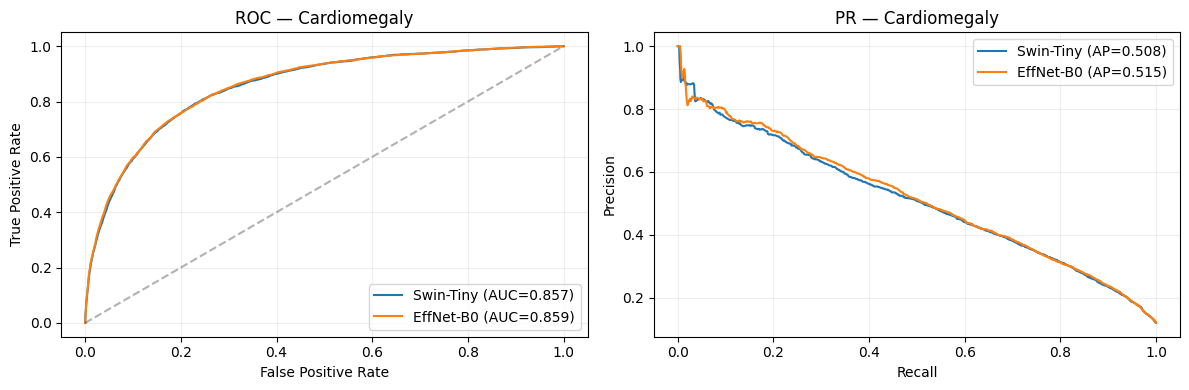

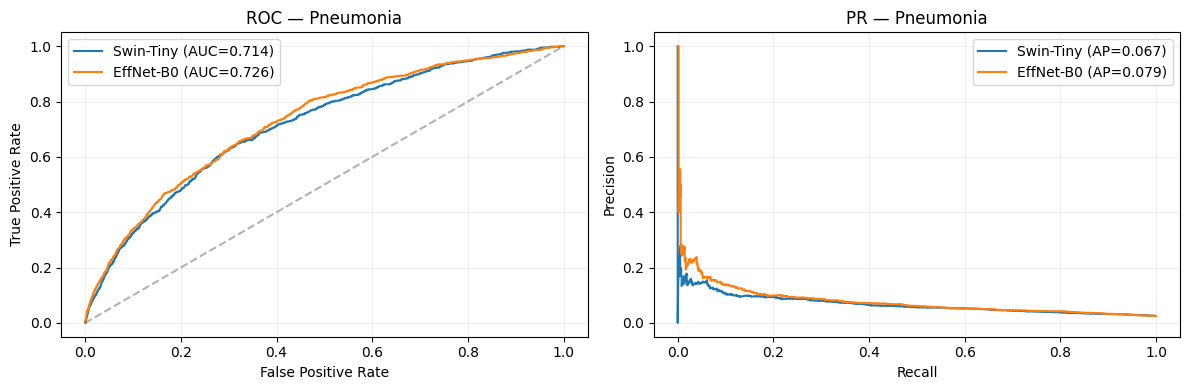

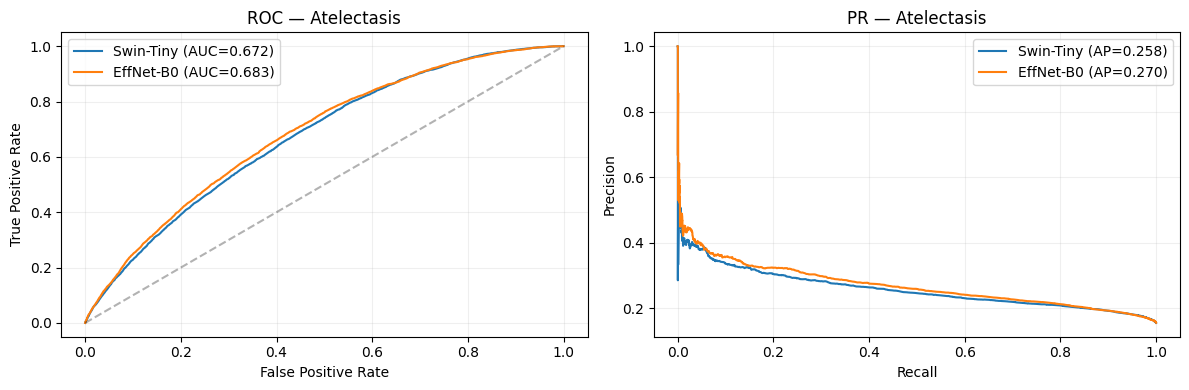

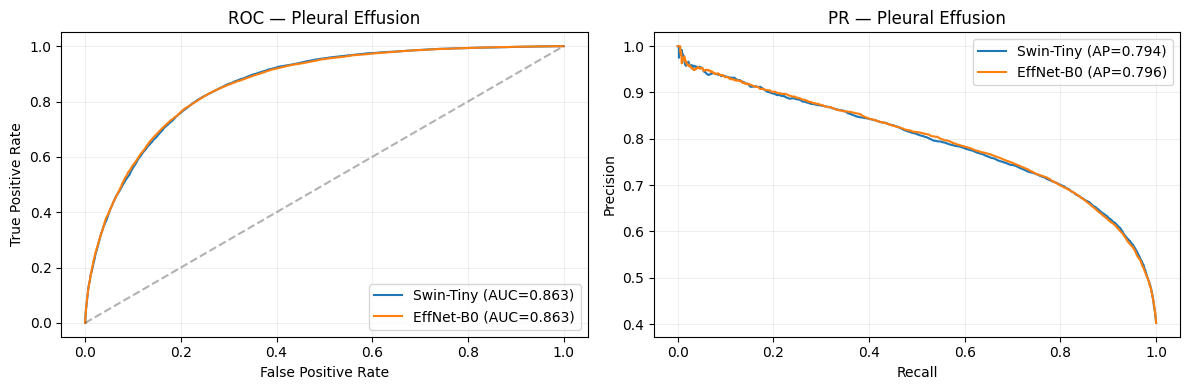

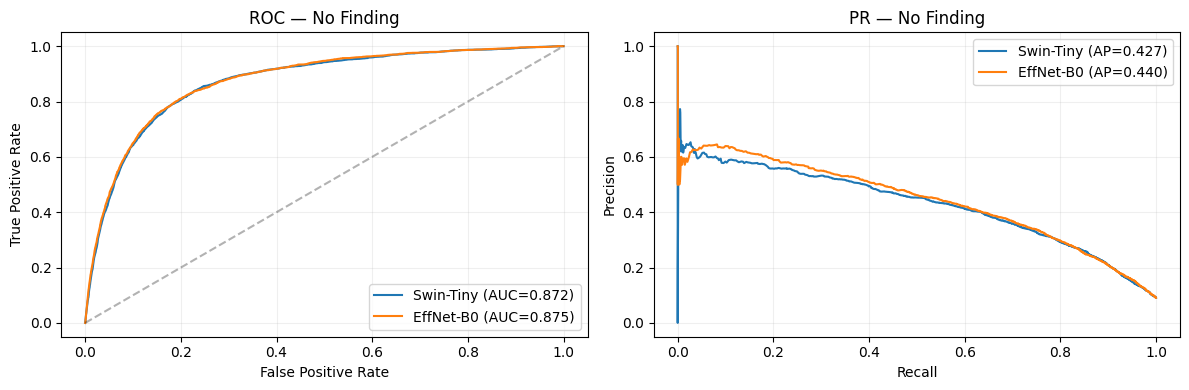

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

def plot_roc_pr_overlap(
    y_true_a, y_pred_a, 
    y_true_b=None, y_pred_b=None, 
    label_names=None,
    name_a="Swin-T", name_b="EffNet-B0"
):
    """
    y_true_a, y_pred_a: (N, C) for model A (required)
    y_true_b, y_pred_b: (N, C) for model B (optional; if None, plots only A)
    label_names: list of class names
    """
    y_true_a = np.asarray(y_true_a)
    y_pred_a = np.asarray(y_pred_a)
    assert y_true_a.shape == y_pred_a.shape

    has_b = (y_true_b is not None) and (y_pred_b is not None)
    if has_b:
        y_true_b = np.asarray(y_true_b)
        y_pred_b = np.asarray(y_pred_b)
        assert y_true_b.shape == y_pred_b.shape == y_true_a.shape

    C = y_true_a.shape[1]
    if label_names is None:
        label_names = [f"Class {i}" for i in range(C)]

    for i, lab in enumerate(label_names):
        yt_a, yp_a = y_true_a[:, i], y_pred_a[:, i]

        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        try:
            fpr_a, tpr_a, _ = roc_curve(yt_a, yp_a)
            auc_a = roc_auc_score(yt_a, yp_a)
            ax[0].plot(fpr_a, tpr_a, label=f"{name_a} (AUC={auc_a:.3f})")
        except ValueError:
            ax[0].text(0.5, 0.5, "Not enough pos/neg samples", ha="center", va="center")
            auc_a = np.nan

        if has_b:
            yt_b, yp_b = y_true_b[:, i], y_pred_b[:, i]
            try:
                fpr_b, tpr_b, _ = roc_curve(yt_b, yp_b)
                auc_b = roc_auc_score(yt_b, yp_b)
                ax[0].plot(fpr_b, tpr_b, label=f"{name_b} (AUC={auc_b:.3f})")
            except ValueError:
                pass

        ax[0].plot([0, 1], [0, 1], "k--", alpha=0.3)
        ax[0].set_title(f"ROC — {lab}")
        ax[0].set_xlabel("False Positive Rate")
        ax[0].set_ylabel("True Positive Rate")
        ax[0].legend()
        ax[0].grid(alpha=0.2)

        # --- PR curve ---
        try:
            prec_a, rec_a, _ = precision_recall_curve(yt_a, yp_a)
            ap_a = average_precision_score(yt_a, yp_a)
            ax[1].plot(rec_a, prec_a, label=f"{name_a} (AP={ap_a:.3f})")
        except ValueError:
            ax[1].text(0.5, 0.5, "Not enough pos samples", ha="center", va="center")

        if has_b:
            try:
                prec_b, rec_b, _ = precision_recall_curve(yt_b, yp_b)
                ap_b = average_precision_score(yt_b, yp_b)
                ax[1].plot(rec_b, prec_b, label=f"{name_b} (AP={ap_b:.3f})")
            except ValueError:
                pass

        ax[1].set_title(f"PR — {lab}")
        ax[1].set_xlabel("Recall")
        ax[1].set_ylabel("Precision")
        ax[1].legend()
        ax[1].grid(alpha=0.2)

        plt.tight_layout()
        plt.show()

plot_roc_pr_overlap(
    ytrue_swin, ypred_swin,
    ytrue_eff,  ypred_eff,
    label_names=LABELS,
    name_a="Swin-Tiny", name_b="EffNet-B0"
)

In [16]:
def patient_bootstrap_auc_pvalue(df_test, ytrue_a, ypred_a, ytrue_b, ypred_b, label_cols, n_boot=300, seed=42):
    rng = np.random.default_rng(seed)
    pat_to_idx = {}
    pats = df_test["patient"].values
    for idx, pat in enumerate(pats):
        pat_to_idx.setdefault(pat, []).append(idx)
    pvals, diffs = {}, {}
    patient_list = list(pat_to_idx.keys())
    for j,lab in enumerate(label_cols):
        diffs_j = []
        for nb in range(n_boot):
            print(nb, end='\r')
            boots = rng.choice(patient_list, size=len(patient_list), replace=True)
            idxs = sum([pat_to_idx[p] for p in boots], [])
            try:
                auc_a = roc_auc_score(ytrue_a[idxs, j], ypred_a[idxs, j])
                auc_b = roc_auc_score(ytrue_b[idxs, j], ypred_b[idxs, j])
                diffs_j.append(auc_b - auc_a)
            except ValueError:
                pass
        if len(diffs_j)==0:
            pvals[lab] = np.nan; diffs[lab] = np.nan
        else:
            diffs_j = np.array(diffs_j)
            mean_diff = float(np.mean(diffs_j))
            p = (np.sum(np.abs(diffs_j) >= np.abs(mean_diff)) + 1) / (len(diffs_j) + 1)
            pvals[lab] = float(p); diffs[lab] = mean_diff
    diffs["macro"] = float(np.nanmean([diffs[c] for c in label_cols]))
    pvals["macro"] = float(np.nanmax([pvals[c] for c in label_cols]))
    return pvals, diffs

pvals, diffs = patient_bootstrap_auc_pvalue(df_test, ytrue_eff, ypred_eff, ytrue_swin, ypred_swin, LABELS, n_boot=100, seed=SEED)
print("Mean AUC diffs (Swin - EffNet):", diffs)
print("Bootstrap p-values:", pvals)


Mean AUC diffs (Swin - EffNet): {'Cardiomegaly': -0.0019609811535888865, 'Pneumonia': -0.010760867781482275, 'Atelectasis': -0.010783626827210752, 'Pleural Effusion': 1.8993635707187373e-06, 'No Finding': -0.0030464380728487685, 'macro': -0.005310002894311993}
Bootstrap p-values: {'Cardiomegaly': 0.46534653465346537, 'Pneumonia': 0.504950495049505, 'Atelectasis': 0.504950495049505, 'Pleural Effusion': 1.0, 'No Finding': 0.5445544554455446, 'macro': 1.0}


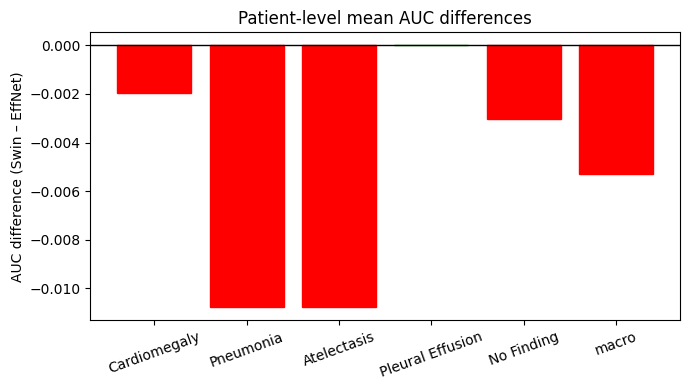

In [17]:
labels = list(diffs.keys())
values = np.array([diffs[k] for k in labels])

plt.figure(figsize=(7,4))
bars = plt.bar(labels, values)

# color by sign: blue if Swin worse, green if better
for b, v in zip(bars, values):
    b.set_color('green' if v > 0 else 'red')

plt.axhline(0, color='black', linewidth=1)
plt.ylabel("AUC difference (Swin – EffNet)")
plt.title("Patient-level mean AUC differences")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

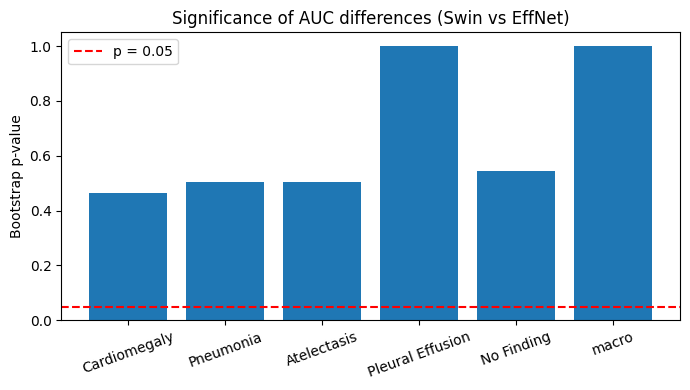

In [18]:
labels = list(pvals.keys())
pvalues = np.array([pvals[k] for k in labels])

plt.figure(figsize=(7,4))
plt.bar(labels, pvalues)
plt.axhline(0.05, color='red', linestyle='--', label='p = 0.05')
plt.ylim(0, 1.05)
plt.ylabel("Bootstrap p-value")
plt.title("Significance of AUC differences (Swin vs EffNet)")
plt.xticks(rotation=20)
plt.legend()
plt.tight_layout()
plt.show()